In [1]:
import logging
logging.basicConfig(
#         filename='file1.log',
        level=logging.WARNING,
        format='%(asctime)s %(levelname)s:\t%(message)s',
        datefmt='%Y-%m-%d %H:%M:%S')

# 1 этап. Нахождение ссылок на людей.

In [2]:
import re
import requests
from bs4 import BeautifulSoup
import time
from tqdm import tqdm_notebook
import sys
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
from datetime import datetime
from lxml import etree, html as lhtml
import pandas as pd

In [3]:
actors_links_txt = 'actors_links.txt'
popular_main_page = 'https://www.kinopoisk.ru/popular/names/day/2020-06-12/'
site_name = 'https://www.kinopoisk.ru'

attempts_number = 2

In [135]:
def process_one_author_books(popular_main_page, site_name, f_write):
    def find_the_number_of_iterations(author_soup):
        total_pages = 50
        total_actors = 10000
        return total_pages, total_actors
    def process_main_page(author_soup, curr_address):        
        r_get = requests.get(curr_address)
        tree = lhtml.fromstring(r_get.text)
        table_el = tree.xpath('//div[@class="stat js-rum-hero"]')
        lst_el = table_el[0].xpath('//a[@style="font:100 12px arial,sans-serif"]/attribute::href')
        if books_descs is None:
            logging.error('no books found:\t{}'.format(curr_address))
            return
        for it in lst_el:
            print(site_name + it, file=f_write)
        logging.info('success:\t\t{}'.format(curr_address))  
    def process_fork_page(curr_address):
        for i in range(1, attempts_number+1):
            r_get = requests.get(curr_address)
            if (r_get.ok):
                break
            logging.error('bad get request ({}/{}):\t{}'.format(i, attempts_number, curr_address))
            time.sleep(1)
        if not (r_get.ok):
            return
        author_soup = BeautifulSoup(r_get.text, 'lxml')
        process_main_page(author_soup, curr_address)

    for i in range(1, attempts_number+1):
        r_get = requests.get(popular_main_page)
        if (r_get.ok):
            break
        logging.error('bad get request ({}/{}):\t{}'.format(i, attempts_number, popular_main_page))
        time.sleep(1)
    if not (r_get.ok):
        return
    
    author_soup = BeautifulSoup(r_get.text, 'lxml')   
    total_pages, _ = find_the_number_of_iterations(author_soup)
    pages = []
    for curr_page in range(2, total_pages+1):
        pages.append(popular_main_page + 'page/{}/'.format(str(curr_page)))    
#     with ThreadPool(processes=total_pages) as pool:
#         pool.map(process_fork_page, pages)
    process_main_page(author_soup, popular_main_page)
    for page in pages:
        process_fork_page(page)

In [133]:
with open(actors_links_txt, 'w') as f_write:
    process_one_author_books(popular_main_page, site_name, f_write)
logging.info('completed')        

# 2 этап. Обкачка этих ссылок.

In [59]:
from selenium import webdriver

import html
from time import sleep
from selenium.common.exceptions import NoSuchElementException        

In [304]:
def process_one_page(card_data):
    url, driver, f_write, rank = card_data
    def check_exists_by_xpath(xpath, driver):
        try:
            driver.find_element_by_xpath(xpath)
        except NoSuchElementException:
            return False
        return True
    driver.get(url)      
    sleep(1.5)

    name = driver.find_element_by_xpath('//h1[@class="moviename-big"]').text
    print('{}\t{}'.format(rank, name), file=f_write, end='')
    favors = driver.find_element_by_xpath('//div[@class="num"]').text
    if favors != '':
        favors = int(favors)
        print('\t{}'.format(favors), file=f_write, end='')
    foldrs = re.search(r'[0-9]+', driver.find_element_by_xpath('//div[@class="text"]').text)
    if foldrs is not None:
        foldrs = int(foldrs[0])
        print('\t{}'.format(foldrs), file=f_write, end='') 
    awards = check_exists_by_xpath('//table[@id="awardsBlock"]', driver)
    print('\t{}'.format(foldrs, awards), file=f_write, end='')

    describe = (e.text for e in driver.find_elements_by_xpath('//table[@class="info"]//tr'))
    describe = list(filter(None, map(str.lower, describe)))    
    for item in describe: 
        if item[:7] == 'карьера':
            career = item[8:].replace(', ', ';').replace(',', ';')
            print('\t{}'.format(career), file=f_write, end='')
        elif item[:4] == 'рост':
            length = float(item[5:-2]) 
            print('\t{}'.format(length), file=f_write, end='')
        elif item[:13] == 'дата рождения':
            b_day = item[14:].split(sep=',') 
            if len(b_day) != 2:
                continue
            day = int(b_day[0].split()[0])
            mounth  = b_day[0].split()[1]
            year = int(re.search(r'[0-9]{4,}', b_day[1])[0])
            print('\t{}\t{}\t{}'.format(year, day, mounth), file=f_write, end='')
        elif item[:14] == 'место рождения':
            b_place = item[15:].split(sep=',')
#             if len(b_place) == 0:
#                 continue
            city = b_place[0]
            print('\t{}'.format(city), file=f_write, end='')
            if len(b_place) != 1:
                country = b_place[1][1:]
                print('\t{}'.format(country), file=f_write, end='')
        elif item[:5] == 'жанры':
            genres = ';'.join([i[1:] for i in item[5:].split(sep=',')])
            print('\t{}'.format(genres), file=f_write, end='')
        elif item[:7] == 'супруга':
            family = item[8:].split(sep='\n')
            children = ';'.join([re.search(r'\.\.\. .*(ребен|детей)', i)[0][4:-6] for i in family \
                                 if re.search(r'\.\.\. .*(ребен|детей)', i) is not None])
            spouses = ';'.join([i for i in family if re.search(r'\.\.\. .*(ребен|детей)', i) is None])
            print('\t{}\t{}'.format(children, spouses), file=f_write, end='')
        elif item[:13] == 'всего фильмов':
            total_films = item[14:].split(sep=',')
            films_number = int(total_films[0])
            career_years = total_films[1][1:].split(sep=' — ')
            career_start = int(career_years[0])
            print('\t{}\t{}'.format(films_number, career_start), file=f_write, end='')
            if len(career_years) != 1:                
                career_finish = int(career_years[1])
                print('\t{}'.format(career_finish), file=f_write, end='')

    print('', file=f_write)
    logging.info('success:\t\t{}'.format(url))  

In [307]:
nrun = 8
start = 600
finish = 700

def count_lines(filename):
    with open(filename) as file:
        return sum(chunk.count('\n') for chunk in iter(lambda: file.read(), ''))

cart_table_txt = 'cart_table({}).txt'.format(nrun)
actors_links_txt = 'actors_links_ranked.txt'
total_actors = count_lines(actors_links_txt)

In [309]:
pbar = tqdm_notebook(total=total_actors)
pbar.update(start)

with webdriver.Firefox() as driver:
    with open(cart_table_txt, 'w') as f_write:
        print('rank\tname\tfavors\tfolders\tawards\tcareer\theight\tyear\tday\tmounth\tcity\tcountry' +\
              '\tgenres\tchildren\tspouses\ttotal_films\tcareer_start\tcaree_finish', file=cart_table)
        card_tuples = []
        with open(actors_links_txt, 'r') as f_read:
            for rank, item in enumerate(f_read):
                card_tuples.append((item[:-2], driver, f_write, rank+1))
        
        for card_data in card_tuples[start:finish]:
            process_one_page(card_data)
            pbar.update(1)

NoSuchElementException: Message: Unable to locate element: //h1[@class="moviename-big"]


# 3. DataMining

In [378]:
df = pd.read_csv('total_cart_table', sep='\t')
df.head(2)

,rank,name,favors,folders,awards,career,height,year,day,mounth,city,country,genres,children,spouses,total_films,career_start,caree_finish
0,1,Михаил Ефремов,693,4705,False,актер;актер: дубляж;сценарист,1.75,1963,10,ноября,москва,ссср (россия),комедия;драма;мелодрама,один;один;один;трое,ася воробьева (развод);евгения добровольская (...,195.0,1976.0,2020.0
1,2,Гай Ричи,5353,39861,True,режиссер;сценарист;продюсер;актер,1.8,1968,10,сентября,хатфилд,хартвордшир,короткометражка;криминал;боевик,двое;трое,мадонна (развод);джеки эйнсли,62.0,1995.0,2021.0


In [379]:
def fit_mounth(x):
    if x == 'января':
        return 1
    elif x == 'февраля':
        return 2
    elif x == 'марта':
        return 3
    elif x == 'апреля':
        return 4
    elif x == 'мая':
        return 5
    elif x == 'июня':
        return 6
    elif x == 'июля':
        return 7
    elif x == 'августа':
        return 8
    elif x == 'сентября':
        return 9
    elif x == 'октября':
        return 10
    elif x == 'ноября':
        return 11
    elif x == 'декабря':
        return 12
    else:
        return 

In [380]:
def find_zodiac(data):
    x = data % 10000
    if (321 <= x) and (x <= 420):
        return 'Aries'
    elif (421 <= x) and (x <= 520):
        return 'Taurus'
    elif (521 <= x) and (x <= 621):
        return 'Gemini'
    elif (622 <= x) and (x <= 722):
        return 'Cancer'
    elif (723 <= x) and (x <= 823):
        return 'Leo'
    elif (824 <= x) and (x <= 921):
        return 'Virgo'
    elif (922 <= x) and (x <= 1022):
        return 'Libra'
    elif (1023 <= x) and (x <= 1121):
        return 'Scorpio'
    elif (1122 <= x) and (x <= 1221):
        return 'Sagittarius'
    elif (1222 <= x) or (x <= 120):
        return 'Capricorn'
    elif (121 <= x) and (x <= 219):
        return 'Aquarius'
    elif (220 <= x) and (x <= 320):
        return 'Pisces'
    else:
        return 

In [381]:
df.loc[:, 'new_mounth'] = df['mounth'].map(fit_mounth)
df.dropna(subset=['new_mounth'], inplace=True)
df['new_mounth'] = df['new_mounth'].astype(int)
df['year'] = df['year'].astype(int)
df['day'] = df['day'].astype(int)
df['data'] = df['year']*10000 + df['new_mounth']*100 + df['day']

df.loc[:, 'zodiac'] = df['data'].map(find_zodiac)

In [382]:
df.head(2)

,rank,name,favors,folders,awards,career,height,year,day,mounth,...,country,genres,children,spouses,total_films,career_start,caree_finish,new_mounth,data,zodiac
0,1,Михаил Ефремов,693,4705,False,актер;актер: дубляж;сценарист,1.75,1963,10,ноября,...,ссср (россия),комедия;драма;мелодрама,один;один;один;трое,ася воробьева (развод);евгения добровольская (...,195.0,1976.0,2020.0,11,19631110,Scorpio
1,2,Гай Ричи,5353,39861,True,режиссер;сценарист;продюсер;актер,1.8,1968,10,сентября,...,хартвордшир,короткометражка;криминал;боевик,двое;трое,мадонна (развод);джеки эйнсли,62.0,1995.0,2021.0,9,19680910,Virgo


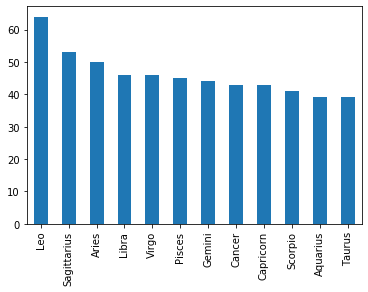

In [375]:
df['zodiac'].value_counts().plot.bar()

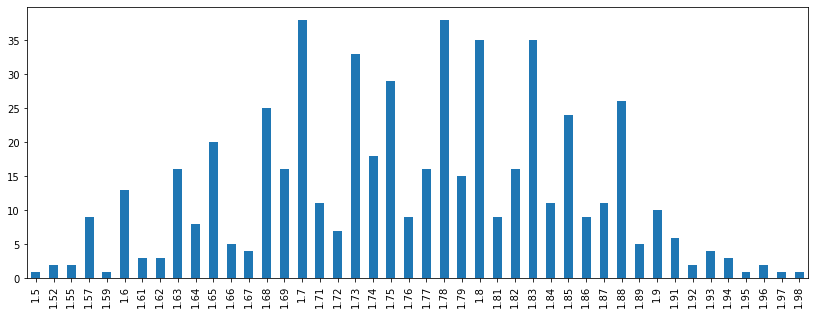

In [414]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize= (14,5))
df['height'].value_counts().sort_index().plot.bar()

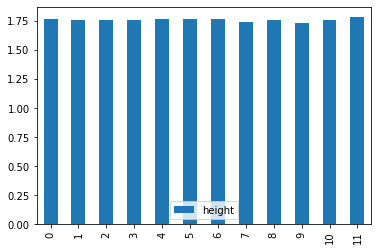

In [413]:
import numpy as np
df['height'] = df['height'].astype(float)
df.groupby(by=['zodiac'], as_index=False)['height'].mean().plot.bar()

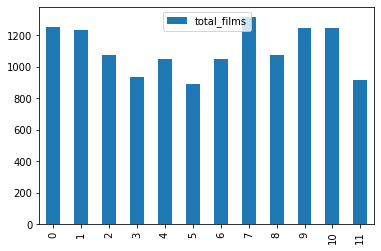

In [415]:
df.groupby(by=['zodiac'], as_index=False)['total_films'].mean().plot.bar()

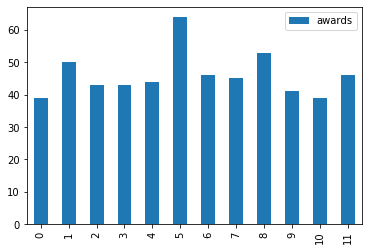

In [427]:
df['awards'] = df['awards'].astype(bool).astype(int)
df.groupby(by=['zodiac'], as_index=False)['awards'].sum().plot.bar()

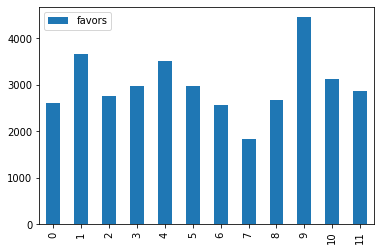

In [433]:
df.groupby(by=['zodiac'], as_index=False)['favors'].mean().plot.bar()

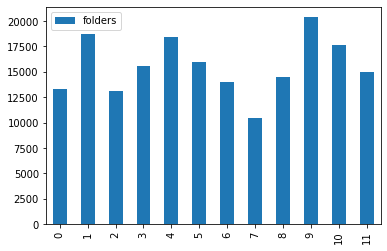

In [432]:
df['folders'] = df['folders'].astype(int)
df.groupby(by=['zodiac'], as_index=False)['folders'].mean().plot.bar()